# GPT-4o音视频实战
GPT-4o（“o”代表“o​​mni”）旨在处理文本、音频和视频输入的组合，并可以生成文本、音频和图像格式的输出。

背景
在 GPT-4o 之前，用户可以使用语音模式与 ChatGPT 进行交互，该模式使用三个独立的模型运行。GPT-4o 将这些功能集成到一个针对文本、视觉和音频进行训练的模型中。这种统一的方法可确保所有输入（无论是文本、视觉还是听觉）都由同一个神经网络进行统一处理。

## 安装 ffmpeg 

ffmpeg - https://www.gyan.dev/ffmpeg/builds/

Ubuntu: sudo apt install ffmpeg  
在 Windows 系统上安装用于视频处理的 ffmpeg、opencv-python 和 moviepy 包的步骤如下：

下载 ffmpeg：
访问 ffmpeg 官方下载页面。 找到 Windows 版本的 ffmpeg，并下载适合你系统的压缩包。 

解压并配置 ffmpeg：
将下载的压缩包解压到一个你方便访问的文件夹（例如 C:\ffmpeg）。 确保文件夹结构如下：C:\ffmpeg\bin\ffmpeg.exe。 添加 ffmpeg 到系统路径：

右键点击“此电脑”或“计算机”，选择“属性”。 选择“高级系统设置”。 在“系统属性”窗口中，点击“环境变量”。 在“系统变量”部分，找到并选中“Path”，然后点击“编辑”。 点击“新建”，然后输入 C:\ffmpeg\bin，点击“确定”。 关闭所有窗口，并重启命令提示符以应用更改。 

## 安装 opencv-python 和 moviepy 

pip install opencv-python  
pip install moviepy


In [ ]:
# %pip install opencv-python
# %pip install moviepy

## 导入视频

In [1]:
import cv2
from moviepy.editor import VideoFileClip
import time
import base64

VIDEO_PATH = "Good_Driver.mp4"
MODEL = 'gpt-4o'

## 把视频和声音转换成模型可读的格式

In [2]:
# 导入所需的库
import os
import cv2 # 视频处理
import base64 # 编码帧
from moviepy.editor import VideoFileClip # 音频处理

VIDEO_FILE = "Good_Driver.mp4"

def extract_frames_and_audio(video_file, interval=2):
    encoded_frames = []
    file_name, _ = os.path.splitext(video_file)

    video_capture = cv2.VideoCapture(video_file)
    total_frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
    frames_interval = int(frame_rate * interval)
    current_frame = 0

    # 循环遍历视频并以指定的采样率提取帧
    while current_frame < total_frame_count - 1:
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        success, frame = video_capture.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        encoded_frames.append(base64.b64encode(buffer).decode("utf-8"))
        current_frame += frames_interval
    video_capture.release()

    # 从视频中提取音频
    audio_output = f"{file_name}.mp3"
    video_clip = VideoFileClip(video_file)
    video_clip.audio.write_audiofile(audio_output, bitrate="32k")
    video_clip.audio.close()
    video_clip.close()

    print(f"提取了 {len(encoded_frames)} 帧")
    print(f"音频提取到 {audio_output}")
    return encoded_frames, audio_output

# 每秒提取1帧（采样率）
encoded_frames, audio_output = extract_frames_and_audio(VIDEO_FILE, interval=1)


MoviePy - Writing audio in Good_Driver.mp3


MoviePy - Done.
提取了 33 帧
音频提取到 Good_Driver.mp3


## 显示视频帧和音频文件

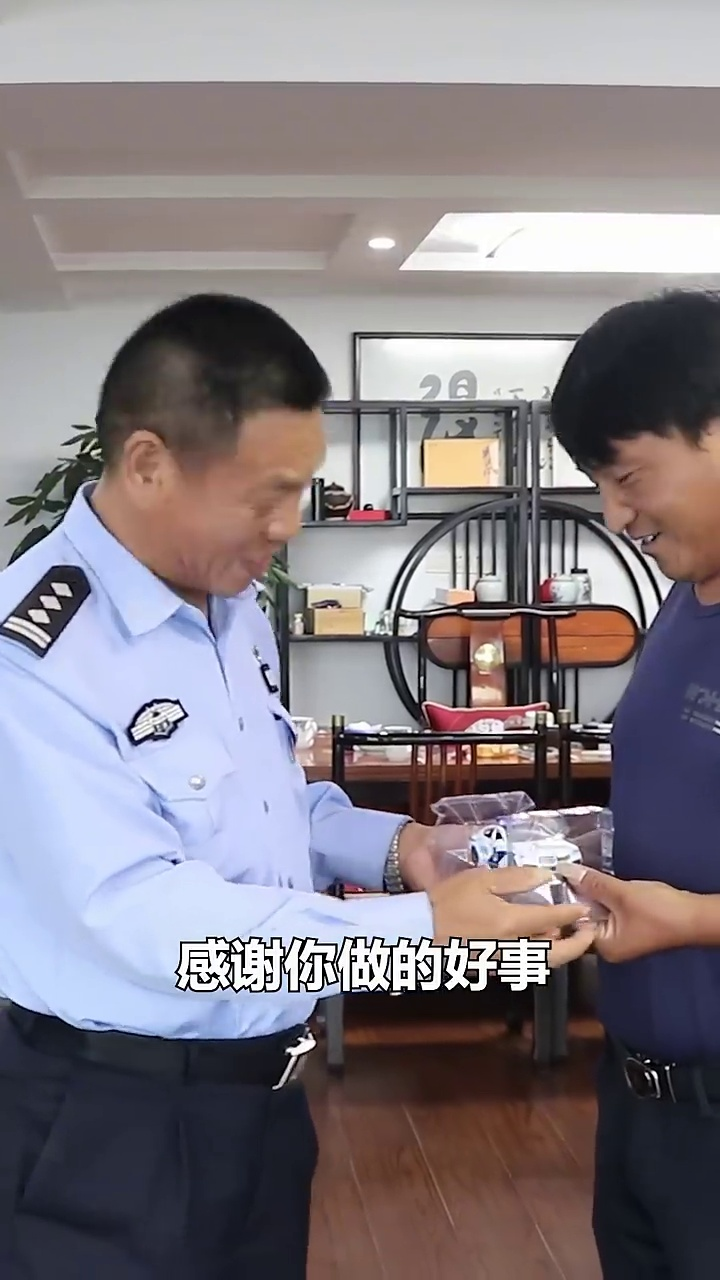

In [4]:
# 显示视频帧和音频文件
from IPython.display import Image, display, Audio, Markdown
display_handle = display(None, display_id=True)
for img in encoded_frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.025)

Audio(audio_output)

## GPT-4o多模态处理

**说明** 

虽然无法直接将视频发送到 API，但如果您采样帧然后将其作为图像提供，GPT-4o 可以理解视频。它在此任务上的表现比 GPT-4 Turbo 更好。

由于 API 中的 GPT-4o 尚不支持音频输入，这里我们将结合使用 GPT-4o 和 Whisper 来处理所提供视频的音频和视频。

In [5]:
from openai import OpenAI 
client = OpenAI()

# Transcribe the audio
transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=open(audio_output, "rb"),
)

response = client.chat.completions.create(
    model='gpt-4o',
    messages=[
    {"role": "system", "content":"""请生成Markdown格式的视频和音频文本的整体介绍"""},
    {"role": "user", "content": [
        "视频帧",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, encoded_frames),
        {"type": "text", "text": f"音频文本: {transcription.text}"}
        ],
    }
],
    temperature=0,
)
print(response.choices[0].message.content)

### 视频整体介绍

#### 视频内容概述
视频展示了在宁波奉化的一条道路上，由于路面凹陷，存在安全隐患。一辆工程车的司机发现了这一情况后，迅速采取了行动。他停车并打开双闪灯，下车后跑到路边拿起锥形桶，将其放置在凹陷处周围，以警示后方车辆。随后，司机确认安全后，默默离开。视频的最后，当地公安找到这位司机并对他的善举表示感谢，并赠送了纪念品。

#### 视频帧描述
1. **第一帧到第五帧**：展示了一辆蓝色货车经过路面凹陷处，扬起了灰尘。
2. **第六帧到第十帧**：一辆工程车驶入画面，司机发现路面凹陷后，打开双闪灯并下车。
3. **第十一帧到第十五帧**：司机跑到路边，拿起锥形桶。
4. **第十六帧到第二十帧**：司机将锥形桶放置在凹陷处周围，以警示后方车辆。
5. **第二十一帧到第二十五帧**：司机确认安全后，返回车内并离开。
6. **第二十六帧到第二十八帧**：展示了道路维修的画面。
7. **第二十九帧到第三十三帧**：当地公安找到司机并对他的善举表示感谢，赠送了纪念品。

#### 视频字幕
- 近日 宁波奉化 路面凹陷 对来往车辆存在安全隐患
- 工程车驾驶员苏进祥 发现情况后打开双闪灯下车
- 跑去路边拿起锥形桶
- 围起路面凹陷处 警示后方车辆
- 反复确认并报警后 驾车默默离开
- 当地公安后找到苏师傅 并表示感谢
- 感谢你做的好事

#### 音频文本
- 像开启的云 叹声骤落 今生再开 化成沙
- 嘿 还活着的你 只在你眼睛 你不放弃你 你不放弃你

### 总结
这段视频通过展示一位工程车司机在发现路面凹陷后，迅速采取措施警示其他车辆，避免了潜在的交通事故，体现了司机的责任感和社会公德心。当地公安对他的善举表示了感谢，并赠送了纪念品，进一步弘扬了社会正能量。


### 视频整体介绍

#### 视频内容概述
视频展示了在宁波奉化的一条道路上，由于路面凹陷，存在安全隐患。一辆工程车的司机发现了这一情况后，迅速采取了行动。他停车并打开双闪灯，下车后跑到路边拿起锥形桶，将其放置在凹陷处周围，以警示后方车辆。随后，司机确认安全后，默默离开。视频的最后，当地公安找到这位司机并对他的善举表示感谢，并赠送了纪念品。

#### 视频帧描述
1. **第一帧到第五帧**：展示了一辆蓝色货车经过路面凹陷处，扬起了灰尘。
2. **第六帧到第十帧**：一辆工程车驶入画面，司机发现路面凹陷后，打开双闪灯并下车。
3. **第十一帧到第十五帧**：司机跑到路边，拿起锥形桶。
4. **第十六帧到第二十帧**：司机将锥形桶放置在凹陷处周围，以警示后方车辆。
5. **第二十一帧到第二十五帧**：司机确认安全后，返回车内并离开。
6. **第二十六帧到第二十八帧**：展示了道路维修的画面。
7. **第二十九帧到第三十三帧**：当地公安找到司机并对他的善举表示感谢，赠送了纪念品。

#### 视频字幕
- 近日 宁波奉化 路面凹陷 对来往车辆存在安全隐患
- 工程车驾驶员苏进祥 发现情况后打开双闪灯下车
- 跑去路边拿起锥形桶
- 围起路面凹陷处 警示后方车辆
- 反复确认并报警后 驾车默默离开
- 当地公安后找到苏师傅 并表示感谢
- 感谢你做的好事

#### 音频文本
- 像开启的云 叹声骤落 今生再开 化成沙
- 嘿 还活着的你 只在你眼睛 你不放弃你 你不放弃你

### 总结
这段视频通过展示一位工程车司机在发现路面凹陷后，迅速采取措施警示其他车辆，避免了潜在的交通事故，体现了司机的责任感和社会公德心。当地公安对他的善举表示了感谢，并赠送了纪念品，进一步弘扬了社会正能量。

## 问答系统

In [6]:
QUESTION = "Question: 图中的人做了什么?"

In [7]:
qa_visual_response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content": "用视频来回答问题."},
    {"role": "user", "content": [
        "视频帧",
        *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, encoded_frames),
        QUESTION
        ],
    }
    ],
    temperature=0,
)
print("Visual QA:\n" + qa_visual_response.choices[0].message.content)

Visual QA:
图中的人发现了路面上的坑洞，存在安全隐患。他停下车，打开双闪灯，下车后跑到路边拿起锥形桶，并将锥形桶围在坑洞周围，以警示后方车辆。随后，他确认并报告了情况，然后默默离开。当地公安后来找到他，并对他的善举表示感谢，赠送了纪念品。


Visual QA:
图中的人发现路面有坑洞，存在安全隐患，于是他下车拿起路边的锥形桶，围起路面凹陷处，警示后方车辆。之后，当地公安找到他并表示感谢，还送给他纪念品。

In [8]:
qa_audio_response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""用音频来回答问题"""},
    {"role": "user", "content": f"音频文字: {transcription.text}. \n\n {QUESTION}"},
    ],
    temperature=0,
)
print("Audio QA:\n" + qa_audio_response.choices[0].message.content)

Audio QA:
对不起，我无法查看图像或音频文件。如果你能提供更多的文字描述，我会尽力帮助你。


Audio QA:
对不起，根据提供的音频转录内容，没有足够的信息来回答图中的人做了什么。音频转录内容主要是一些诗意的句子，并没有描述具体的行为或动作。请提供更多的上下文或图像描述，以便更好地回答您的问题。

In [9]:
qa_both_response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""用视频和音频文字来回答问题."""},
    {"role": "user", "content": [
        "视频帧",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, encoded_frames),
                        {"type": "text", "text": f"音频文字: {transcription.text}"},
        QUESTION
        ],
    }
    ],
    temperature=0,
)
print("Both QA:\n" + qa_both_response.choices[0].message.content)

Both QA:
图中的人发现路面有一个坑洞，存在安全隐患。他停下车，打开双闪灯，下车后跑到路边拿起锥形桶，然后将锥形桶围在坑洞周围，以警示后方车辆。之后，他确认并报告情况后，默默离开。当地公安后来找到他，并对他的善举表示感谢，赠送了纪念品。


Both QA:
图中的人发现路面有坑洞，存在安全隐患，于是他下车拿起路边的锥形桶，围起路面凹陷处，警示后方车辆。随后，当地公安找到他并表示感谢，还送给他纪念品。